In [22]:
import pandas as pd
import river
from pprint import pprint
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
import itertools
import datetime as dt
from river import ensemble
from river import stream
from river import datasets
from river import facto
from river import compat
from river import tree
from river import neighbors
from river import multioutput
from river import neural_net
from river import dummy
from river import compat
from river import time_series
import numpy as np
import time
from tqdm import tqdm
%matplotlib inline

In [23]:
dati_test = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/ItalyPowerDemand(1)/ItalyPowerDemand_TEST.txt",delim_whitespace=True, index_col=False, header=0, names=('target','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))

dati_train = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/ItalyPowerDemand(1)/ItalyPowerDemand_TRAIN.txt", delim_whitespace=True, index_col=False, header=0, names=('target','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))

dati_train = dati_train.drop("target", axis= 1)
dati_test = dati_test.drop("target", axis= 1)

dati_train = dati_train.stack().reset_index()
dati_test = dati_test.stack().reset_index()

dati_train = dati_train.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'PowerDemandValue'})
dati_train = dati_train[['Count_days','Hours','PowerDemandValue']]

dati_test = dati_test.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'PowerDemandValue'})
dati_test = dati_test[['Count_days','Hours','PowerDemandValue']]

# concateno i due dataset almeno per quanto riguarda lo sviluppo di algoritmi online

dati_complete = pd.concat([dati_train,dati_test])
list_hour = []
i = 0
for a in range(0,dati_complete.shape[0]):
       list_hour.append(i)
       i +=1
       if(i == 24):
              i=0
dati_complete['hour'] = list_hour
dati_complete = dati_complete[['Count_days', 'hour','PowerDemandValue' ]]
dati_complete.to_csv('dati_PowerDemandValue')


dati_complete = pd.read_csv('/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerDemandValue')



dati_complete = dati_complete[['Count_days', 'hour','PowerDemandValue' ]]
dati_complete


def initial_iter():

       path = '/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerDemandValue'

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'PowerDemandValue': float,
                     'hour': int
                     },
              target='PowerDemandValue'
                      )
       return X_y

In [24]:
dati_test

,Count_days,Hours,PowerDemandValue
0,0,00:00-00:59,-1.098737
1,0,01:00-01:59,-1.134565
2,0,02:00-02:59,-1.600334
3,0,03:00-03:59,-1.707820
4,0,04:00-04:59,-1.636163
...,...,...,...
24667,1027,19:00-19:59,0.180490
24668,1027,20:00-20:59,-0.094058
24669,1027,21:00-21:59,0.729587
24670,1027,22:00-22:59,0.210995


In [147]:
dati_train.PowerDemandValue.isna().sum()

0

<AxesSubplot:>

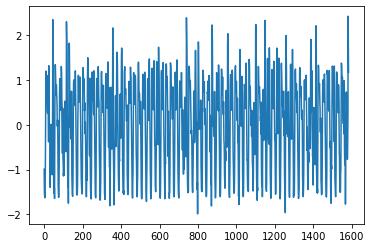

In [148]:
dati_train.PowerDemandValue.plot()

In [149]:
dati_test.PowerDemandValue.isna().sum()

0

<AxesSubplot:>

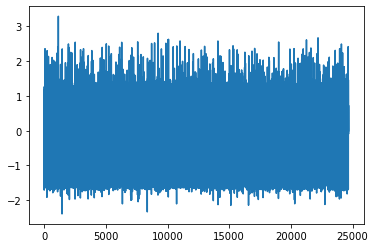

In [25]:
dati_test.PowerDemandValue.plot()

In [153]:
dati_complete.shape[0]

26256

<AxesSubplot:>

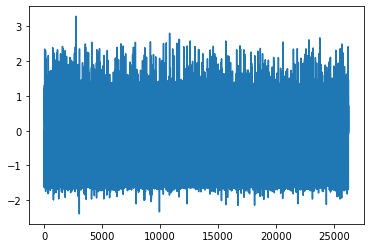

In [154]:
dati_complete['PowerDemandValue'].plot()

In [12]:
X_y = initial_iter()

In [20]:
next(X_y)

({'': '7', 'Count_days': 0, 'hour': 7}, -0.35510183)

100%|██████████| 26256/26256 [00:01<00:00, 18157.36it/s]
/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Execution time: 1.4486308097839355 seconds


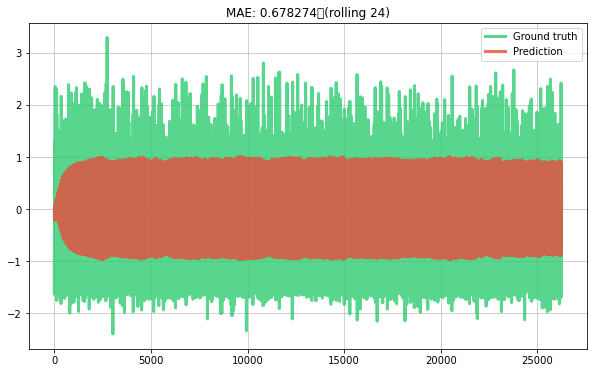

In [26]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( 'hour')
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))


# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in range(0,21256):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 21255:
#               for i in range(21256,26256):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

100%|██████████| 26256/26256 [00:01<00:00, 23500.60it/s]


Execution time: 1.119492769241333 seconds


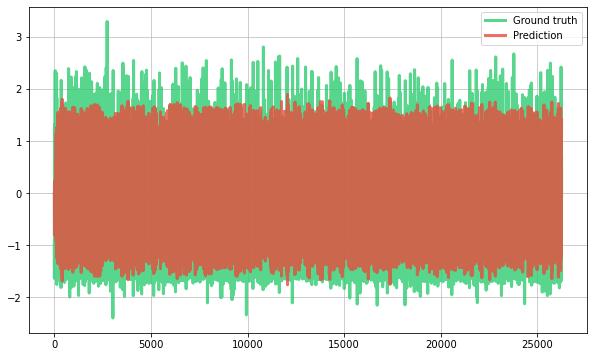

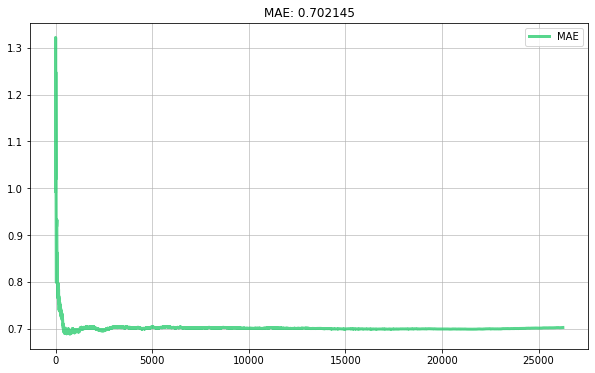

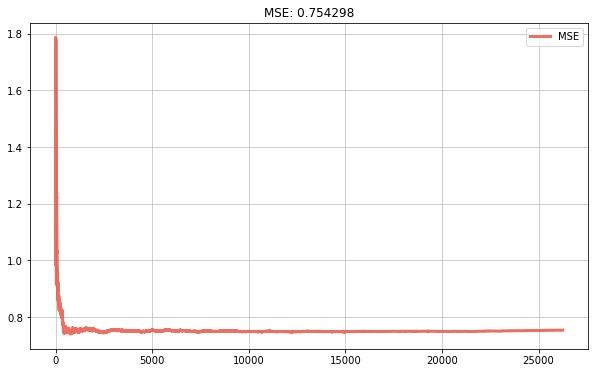

In [21]:
from river import metrics
import matplotlib.pyplot as plt

metric_mae = metrics.MAE()
metric_mse = metrics.MSE()

dates = []
y_trues = []
y_preds = []
metrics_MAE = []
metrics_MSE = []

X_y = initial_iter()


model = compose.Select( 'hour')
model |= preprocessing.StandardScaler()
model |= linear_model.PARegressor(
       C=0.01,
       mode=2,
       eps=0.1,
       learn_intercept=False
)

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae.update(y, y_pred)
       metric_mse.update(y, y_pred)
       metrics_MAE.append(metric_mae.get())
       metrics_MSE.append(metric_mse.get())

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in range(0,21256):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 21255:
#               for i in range(21256,26256):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)


# get the end time
et = time.time()

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, metrics_MAE, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, metrics_MSE, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

100%|██████████| 26256/26256 [10:04<00:00, 43.44it/s]


Execution time: 604.423148393631 seconds


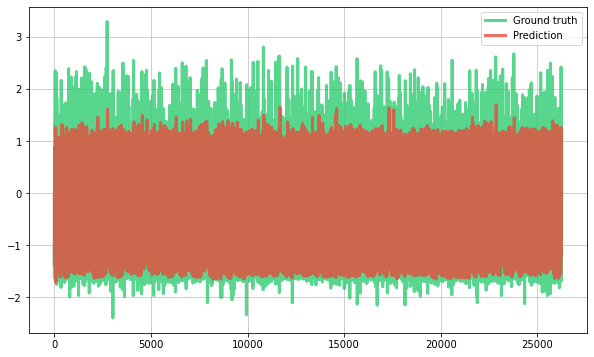

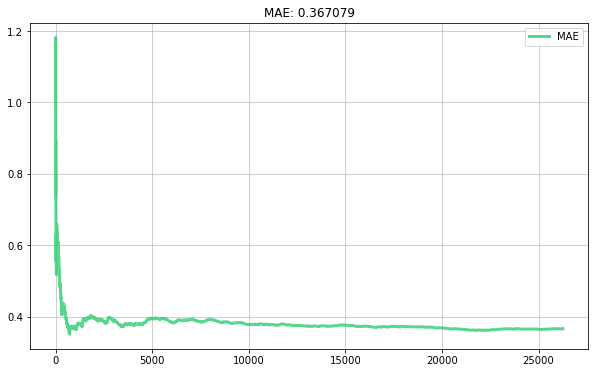

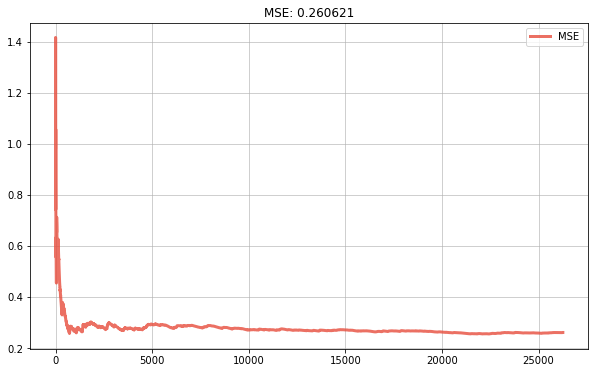

In [27]:
from river import metrics
import matplotlib.pyplot as plt


metric_mae = metrics.MAE()
metric_mse = metrics.MSE()

dates = []
y_trues = []
y_preds = []
metrics_MAE = []
metrics_MSE = []

X_y = initial_iter()

model = compose.Select( 'hour')
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor()

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae.update(y, y_pred)
       metric_mse.update(y, y_pred)
       metrics_MAE.append(metric_mae.get())
       metrics_MSE.append(metric_mse.get())

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in range(0,21256):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 21255:
#               for i in range(21256,26256):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)


# get the end time
et = time.time()

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, metrics_MAE, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, metrics_MSE, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

100%|██████████| 26256/26256 [00:03<00:00, 6770.56it/s]


Execution time: 3.8799989223480225 seconds


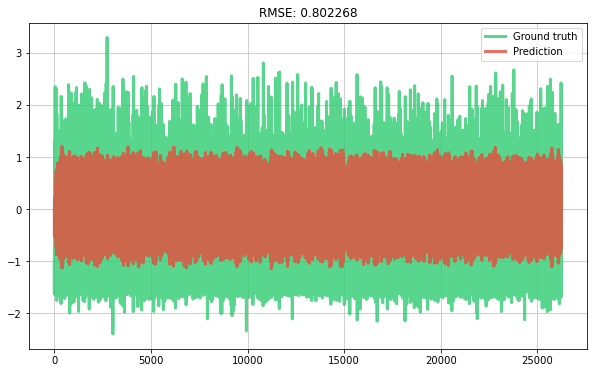

In [62]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( 'hour')
model |= preprocessing.StandardScaler()
model |= ensemble.BaggingRegressor(
       model=linear_model.LinearRegression(),
       n_models=10
)

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in range(0,21256):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 21255:
#               for i in range(21256,26256):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

In [61]:
X_y = initial_iter()

next(X_y)

({'': '0', 'Count_days': 0, 'hour': 0}, -0.99300935)

Text(0.5, 1.0, 'MAE: 229,140,663,523.541351\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


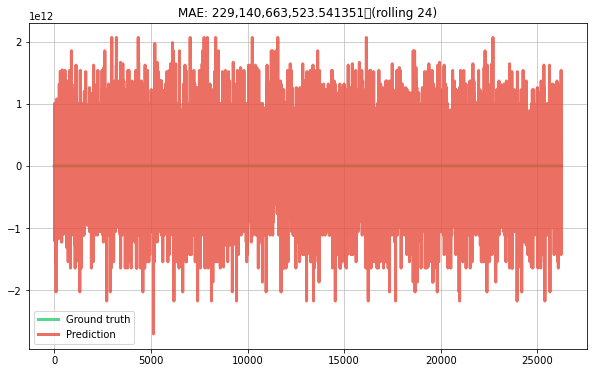

In [121]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

base_model = tree.HoeffdingTreeRegressor(grace_period=50)
model = compose.Select('hour','')
model |= ensemble.SRPRegressor(
       model=base_model,
       training_method='patches',
       n_models=10
)

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in range(0,21256):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 21255:
#               for i in range(21256,26256):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

100%|██████████| 21256/21256 [00:48<00:00, 434.26it/s]

Execution time: 48.95031237602234 seconds


Text(0.5, 1.0, 'RMSE: 0.615021')

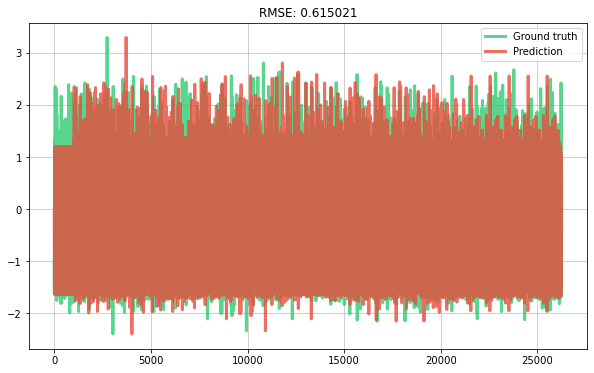

In [63]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select('hour')
model |= neighbors.KNNRegressor(
       n_neighbors=10
)

# get the start time
st = time.time()

# for i in tqdm(range(0,26256)):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#        metric.update(y, y_pred)
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)

for i in tqdm(range(0,21256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go

       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric


       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

       if i == 21255:
              for i in tqdm(range(21256,26256)):
                     x, y = next(X_y)
                     y_pred = model.predict_one(x)
                     model.learn_one(x, y_pred)
                     metric.update(y, y_pred)
                     dates.append(i)
                     y_trues.append(y)
                     y_preds.append(y_pred)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

Text(0.5, 1.0, 'MAE: 0.278782\t(rolling 24)')

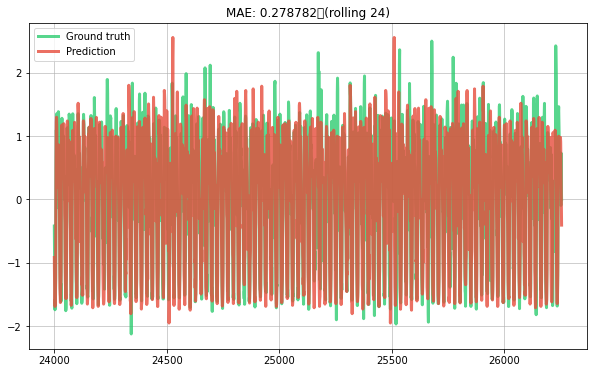

In [58]:
ax.set_title(metric)
ax.set_title(metric)
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates[24000::], y_trues[24000::], lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates[24000::], y_preds[24000::], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

In [135]:
X_y = initial_iter()


model = compose.Select('hour')
model |= neighbors.KNNRegressor(
       window_size= 50,
       n_neighbors=5
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.Rolling(metrics.MAE(), 24),
       delay=24,
       print_every=1000
)

[1,000] MAE: 0.185423	(rolling 24)
[2,000] MAE: 0.22002	(rolling 24)
[3,000] MAE: 0.447688	(rolling 24)
[4,000] MAE: 0.349905	(rolling 24)
[5,000] MAE: 0.345637	(rolling 24)
[6,000] MAE: 0.15954	(rolling 24)
[7,000] MAE: 0.368536	(rolling 24)
[8,000] MAE: 0.90209	(rolling 24)
[9,000] MAE: 0.289489	(rolling 24)
[10,000] MAE: 0.216431	(rolling 24)
[11,000] MAE: 0.216611	(rolling 24)
[12,000] MAE: 0.196972	(rolling 24)
[13,000] MAE: 0.706226	(rolling 24)
[14,000] MAE: 0.356558	(rolling 24)
[15,000] MAE: 0.387464	(rolling 24)
[16,000] MAE: 0.470684	(rolling 24)
[17,000] MAE: 0.83977	(rolling 24)
[18,000] MAE: 0.132102	(rolling 24)
[19,000] MAE: 0.394789	(rolling 24)
[20,000] MAE: 0.445868	(rolling 24)
[21,000] MAE: 0.344545	(rolling 24)
[22,000] MAE: 0.335514	(rolling 24)
[23,000] MAE: 0.145055	(rolling 24)
[24,000] MAE: 0.137832	(rolling 24)
[25,000] MAE: 0.400075	(rolling 24)
[26,000] MAE: 0.562896	(rolling 24)


MAE: 0.367024	(rolling 24)

In [139]:
X_y = initial_iter()
next(X_y)

({'': '0', 'Count_days': 0, 'Hours': '00:00-00:59', 'hour': 0}, -0.99300935)

100%|██████████| 21256/21256 [00:44<00:00, 475.65it/s]

Execution time: 44.69163370132446 seconds


Text(0.5, 1.0, 'MAE: 0.223973\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


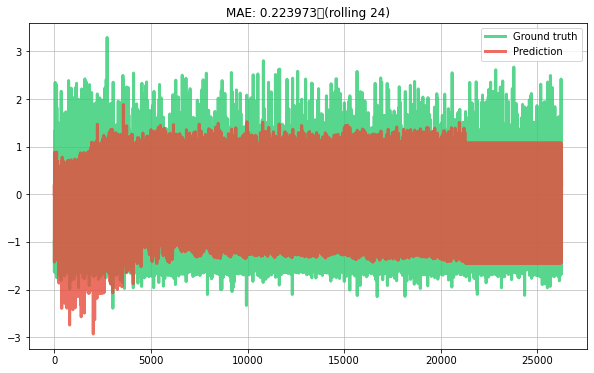

In [158]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select('hour')
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(256,128,64,32),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD()
       )
)

# get the start time
st = time.time()

# for i in tqdm(range(0,26256)):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#        metric.update(y, y_pred)
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)

for i in tqdm(range(0,21256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go

       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric


       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

       if i == 21255:
              for i in range(21256,26256):
                     x, y = next(X_y)
                     y_pred = model.predict_one(x)
                     model.learn_one(x, y_pred)
                     metric.update(y, y_pred)
                     dates.append(i)
                     y_trues.append(y)
                     y_preds.append(y_pred)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

100%|██████████| 26256/26256 [00:06<00:00, 4023.94it/s]

Execution time: 6.527344703674316 seconds


Text(0.5, 1.0, 'MAE: 0.221796\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


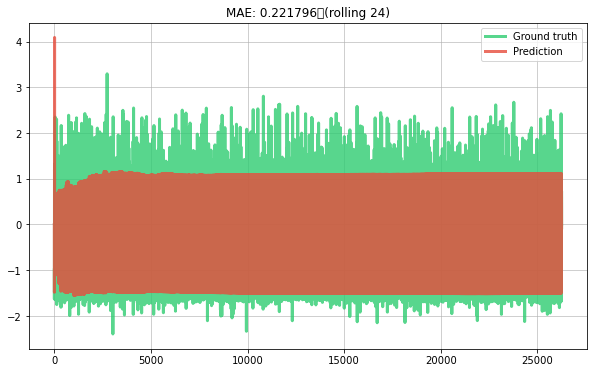

In [46]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select('hour')
model |= tree.HoeffdingAdaptiveTreeRegressor(
       grace_period=20,
       leaf_prediction='adaptive',
       min_samples_split=30
       )

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,21256)):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 21255:
#               for i in range(21256,26256):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

Text(0.5, 1.0, 'MAE: 0.221796\t(rolling 24)')

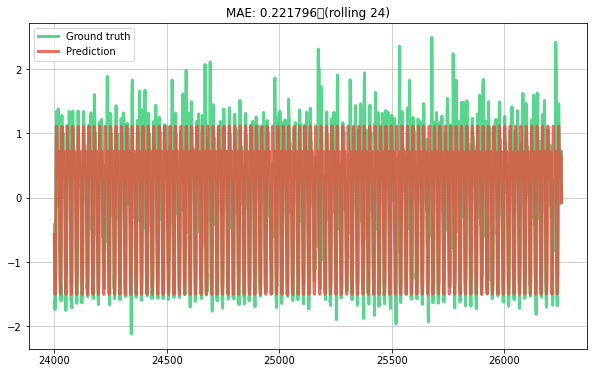

In [47]:
ax.set_title(metric)
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates[24000::], y_trues[24000::], lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates[24000::], y_preds[24000::], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

100%|██████████| 26256/26256 [00:01<00:00, 16253.56it/s]


Execution time: 1.6173126697540283 seconds


Text(0.5, 1.0, 'MSE: 0.235694')

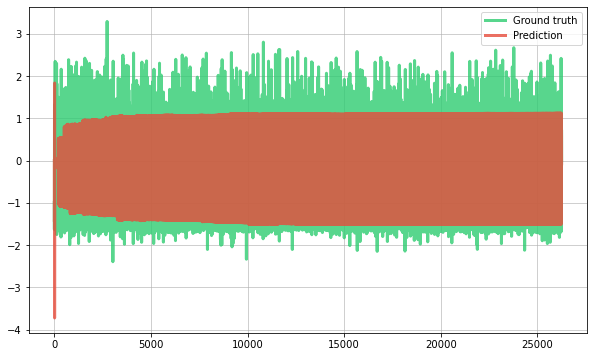

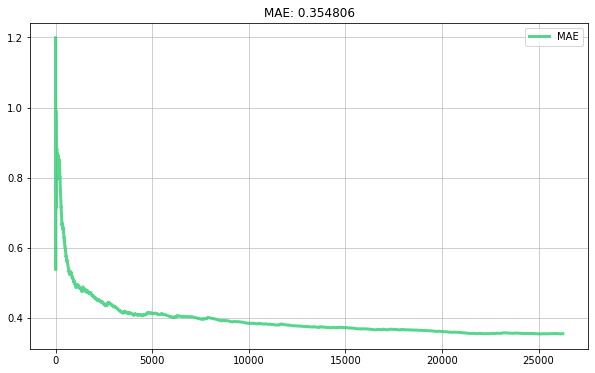

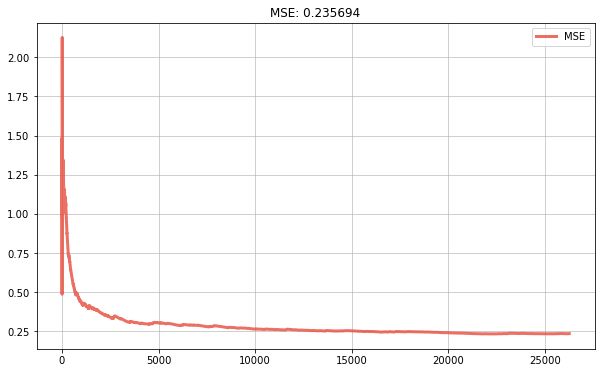

In [7]:
from river import metrics
import matplotlib.pyplot as plt

metric_mae = metrics.MAE()
metric_mse = metrics.MSE()

dates = []
y_trues = []
y_preds = []
metrics_MAE = []
metrics_MSE = []

X_y = initial_iter()

model = compose.Select('hour')
model |= tree.HoeffdingTreeRegressor(
       leaf_prediction='adaptive'
)

# get the start time
st = time.time()

for i in tqdm(range(0,26256)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae.update(y, y_pred)
       metric_mse.update(y, y_pred)
       metrics_MAE.append(metric_mae.get())
       metrics_MSE.append(metric_mse.get())

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,21256)):  #8496
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 21255:
#               for i in range(21256,26256):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, metrics_MAE, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, metrics_MSE, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse)

Text(0.5, 1.0, 'MAE: 0.214819\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


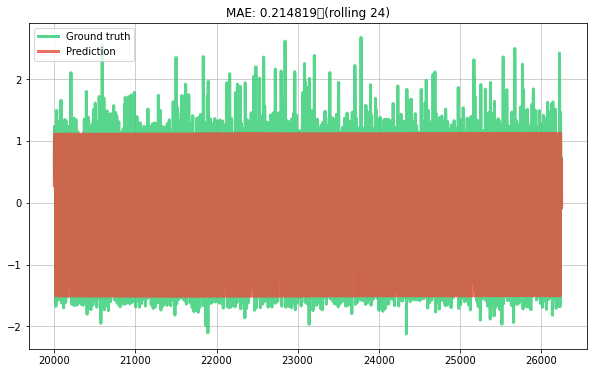

In [45]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates[24000::], y_trues[24000::], lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates[24000::], y_preds[24000::], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)